### Setup

In [4]:
import time
import collections
import pickle
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sliding_window import sliding_window
from label_processing import reassign_labels
from label_processing import print_results
from label_processing import relabel_list
from keras import layers

# Hardcoded number of sensor channels employed in the OPPORTUNITY challenge
NB_SENSOR_CHANNELS = 113

# Hardcoded number of classes in the gesture recognition problem
NUM_CLASSES = 4

# Hardcoded length of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_LENGTH = 24

# Length of the input sequence after convolutional operations
FINAL_SEQUENCE_LENGTH = 6

# Hardcoded step of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_STEP = 12

# Batch Size
BATCH_SIZE = 100

# Number filters convolutional layers
NUM_FILTERS = 64

# Size filters convolutional layers
FILTER_SIZE = 5

# Number of unit in the long short-term recurrent layers
NUM_UNITS_LSTM = 128

### Load the sensor data

In [5]:
def load_dataset(filename):

    f = open(filename, 'rb')
    data = pickle.load(f)
    f.close()

    X_train, y_train = data[0]
    X_test, y_test = data[1]

    print(" ..from file {}".format(filename))
    print(" ..reading instances: train {0}, test {1}".format(X_train.shape, X_test.shape))

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # The targets are casted to int8 for GPU compatibility.
    y_train = y_train.astype(np.uint8)
    y_test = y_test.astype(np.uint8)

    return X_train, y_train, X_test, y_test

print("Loading data...")
X_train, y_train, X_test, y_test = load_dataset('oppChallenge_locomotion.data')

def remove_class(X_train, y_train, X_test, y_test, class_n):
    uy_train = y_train[y_train != class_n]
    uX_train = X_train[y_train != class_n]
    uy_test = y_test[y_test != class_n]
    uX_test = X_test[y_test != class_n]
    
    classes = set(y_train)
    
    for x in range(class_n + 1, len(classes)):
        uy_train[uy_train == x] = x - 1
        uy_test[uy_test == x] = x - 1
        
    return uX_train, uy_train, uX_test, uy_test

# def delete_features():
# RKN^, RKN_, BACK, HIP, R-SHOE, L-SHOE
# 53 Features

#features_delete = np.arange(6, 15)
#features_delete = np.concatenate([features_delete, np.arange(21, 36)])
#features_delete = np.concatenate([features_delete, np.arange(45, 81)])

# 60 Features
#features_delete = np.arange(0, 6)
#features_delete = np.concatenate([features_delete, np.arange(15, 21)])
#features_delete = np.concatenate([features_delete, np.arange(36, 45)])
#features_delete = np.concatenate([features_delete, np.arange(81, 113)])

# 9 Features (Phone)
#features_delete = np.arange(0, 36)
#features_delete = np.concatenate([features_delete, np.arange(45, 113)])

#features_delete = np.concatenate([features_delete, np.arange(6, 113)])

#X_train = np.delete(X_train, features_delete, 1)
#X_test = np.delete(X_test, features_delete, 1)

classes = ["Null", "Stand", "Walk" ,"Sit", "Lie"]

# 0 - null | 1 - stand | 2 - walk | 3 - sit | 4 - lie

X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 0) # remove null
classes.remove("Null")

# 0 - stand | 1 - walk | 2 - sit | 3 - lie

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 1) # remove walking
#classes.remove("Walk")

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 3) # remove walking
#classes.remove("Lie")

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 2) # remove walking
#classes.remove("Sit")

# 0 - stand | 1 - sit | 2 - lie

print(X_train.shape)
print(X_test.shape)

unique, counts = np.unique(y_train, return_counts=True)
label_dict = dict(zip(unique, counts))
print(label_dict)

Loading data...
 ..from file oppChallenge_locomotion.data
 ..reading instances: train (557963, 113), test (118750, 113)
(465668, 113)
(94260, 113)
{0: 231751, 1: 130506, 2: 88883, 3: 14528}


In [6]:
def opp_sliding_window(data_x, data_y, ws, ss):
    data_x = sliding_window(data_x,(ws,data_x.shape[1]),(ss,1))
    data_y = np.asarray([[i[-1]] for i in sliding_window(data_y,ws,ss)])
    return data_x.astype(np.float32), data_y.reshape(len(data_y)).astype(np.uint8)

# Sensor data is segmented using a sliding window mechanism

X_train, y_train = opp_sliding_window(X_train, y_train, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)
X_test, y_test = opp_sliding_window(X_test, y_test, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)

print(" ..after sliding window (testing): inputs {0}, targets {1}".format(X_test.shape, y_test.shape))

#X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
#X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

# Data is reshaped since the input of the network is a 4 dimension tensor
#X_train = X_train.reshape((-1, 1, SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS))
#X_test = X_test.reshape((-1, 1, SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS))

print(X_train.shape)
print(X_test.shape)

 ..after sliding window (testing): inputs (7854, 24, 113), targets (7854,)
(38804, 24, 113)
(7854, 24, 113)


In [4]:
def update_sample_weight(y, label, new_weighting, sample_weight):
    indicies = [i for i,val in enumerate(y) if val==label]
    for index in indicies:
        sample_weight[index] = new_weighting

sample_weight_train = [1] * X_train.shape[0]
#update_sample_weight(y_train, 1, label_dict.get(0) / label_dict.get(1), sample_weight_train)
#update_sample_weight(y_train, 2, label_dict.get(0) / label_dict.get(2), sample_weight_train)
#update_sample_weight(y_train, 3, label_dict.get(0) / label_dict.get(3), sample_weight_train)
update_sample_weight(y_train, 3, 20, sample_weight_train)

In [35]:
# flatten sliding window

def flatten_sliding_window(X_data):
    return X_data.reshape(X_data.shape[0], (X_data.shape[1] * X_data.shape[2]))

In [ ]:
def mean_sliding_window(X):
    rows = X.shape[0]
    n_features = X.shape[2]
    window_mean = np.zeros((rows, n_features))
    for i in range(rows):
        window_mean[i] = np.mean(X_train[i],axis=0).reshape(1, n_features)
    return window_mean

s_X_train = mean_sliding_window(X_train)
s_X_test = mean_sliding_window(X_test)

print(s_X_train.shape)
print(s_X_test.shape)

# PCA

In [275]:
pca = PCA(n_components=0.99)
print("Original shape:", X_test.shape)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
# print('at', x, '% of the variance ======')
print("Transformed shape:", X_test.shape)

Original shape: (94260, 113)
Transformed shape: (94260, 80)


In [27]:
X_train = flatten_sliding_window(X_train)
X_test = flatten_sliding_window(X_test)

In [50]:
NUMBER_OF_CLUSTERS = 6

# time the cluster
start = time.time()

y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(X_train).predict(X_test)
#y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(X_train, sample_weight=sample_weight_train).predict(X_test)

end = time.time()

print("Time:")
print(end - start)

Time:
4.352591514587402


In [51]:
uy_pred = y_pred.copy()
clusters = list(set(y_pred))
clusters.sort()

relabels = reassign_labels(uy_pred, y_test, set(uy_pred))
# relabels = [0, 2, 3, 0, 3, 0, 1, 0]

uy_pred = relabel_list(uy_pred, clusters, relabels)
print_results(uy_pred, y_test, relabels)

Assigned Labels:
[0, 0, 0, 0, 1, 0]

F1:
0.7260729975445086

Accuracy:
0.6289254532202286

ARI:
0.04816860795838542


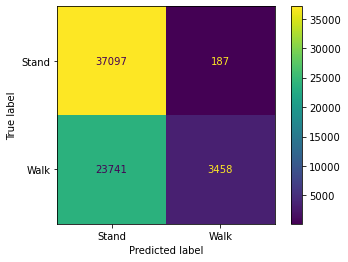

In [52]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_test, uy_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp = disp.plot()

#plt.savefig('confusion_matricies/c4_f113_km8+sw24_12+w.png') # number of classes, features, method
plt.show()

In [219]:
import itertools

# checking specific lists

test_list = list(set(itertools.permutations([2,0,0,1,2,0,0,1])))

f1 = 0
label_list = None
for i in range(0, len(test_list)):
    score = metrics.f1_score(relabel_list(y_pred.copy(), list(test_list[i])), y_test, average='weighted')
    if (score > f1):
        f1 = score
        label_list = list(test_list[i])

uy_pred = y_pred.copy()
uy_pred = relabel_list(uy_pred, label_list)
print_results(uy_pred, y_test, label_list)

KeyboardInterrupt: 

# AE

In [78]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()
# encoder
model.add(Dense(108, activation='relu', input_shape=(24,113)))
model.add(Dense(92, activation='relu'))
model.add(Dense(86, activation='relu'))
# decoder
model.add(Dense(92, activation='relu'))
model.add(Dense(108, activation='relu'))
model.add((Dense(113, activation='sigmoid')))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 24, 108)           12312     
_________________________________________________________________
dense_48 (Dense)             (None, 24, 92)            10028     
_________________________________________________________________
dense_49 (Dense)             (None, 24, 86)            7998      
_________________________________________________________________
dense_50 (Dense)             (None, 24, 92)            8004      
_________________________________________________________________
dense_51 (Dense)             (None, 24, 108)           10044     
_________________________________________________________________
dense_52 (Dense)             (None, 24, 113)           12317     
Total params: 60,703
Trainable params: 60,703
Non-trainable params: 0
_________________________________________________

In [8]:
from keras.callbacks import TensorBoard

model.fit(X_train, X_train, epochs=20, batch_size=100, callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/20
4657/4657 [==============================] - 12s 2ms/step - loss: 0.0025
Epoch 2/20
4657/4657 [==============================] - 13s 3ms/step - loss: 8.6150e-04
Epoch 3/20
4657/4657 [==============================] - 11s 2ms/step - loss: 6.9383e-04
Epoch 4/20
4657/4657 [==============================] - 12s 3ms/step - loss: 6.1735e-04
Epoch 5/20
4657/4657 [==============================] - 13s 3ms/step - loss: 5.7386e-04
Epoch 6/20
4657/4657 [==============================] - 11s 2ms/step - loss: 5.3558e-04
Epoch 7/20
4657/4657 [==============================] - 13s 3ms/step - loss: 5.0579e-04
Epoch 8/20
4657/4657 [==============================] - 11s 2ms/step - loss: 4.8288e-04
Epoch 9/20
4657/4657 [==============================] - 16s 3ms/step - loss: 4.6600e-04
Epoch 10/20
4657/4657 [==============================] - 11s 2ms/step - loss: 4.5447e-04
Epoch 11/20
4657/4657 [==============================] - 12s 3ms/step - loss: 4.4605e-04
Epoch 12/20
4657/4657 [===========

In [9]:
encoder = keras.Model(inputs=model.inputs, outputs=model.layers[2].output)

In [10]:
encoded_train = encoder.predict(X_train, verbose=0)
encoded_test = encoder.predict(X_test, verbose=0)
print(encoded_train.shape)
print(encoded_test.shape)

(465668, 86)
(94260, 86)


# CAE

In [ ]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Sequential

model = Sequential()
# encoder
model.add(Conv1D(128, 3, activation='relu', input_shape=(SLIDING_WINDOW_LENGTH, 113), padding="same"))
model.add(MaxPooling1D(2, padding="valid"))
model.add(Conv1D(64, 3, activation="relu", padding="same"))
model.add(MaxPooling1D(2, padding="valid"))
# decoder
model.add(Conv1D(64, 3, activation="relu", padding="same"))
model.add(UpSampling1D(2))
model.add(Conv1D(128, 3, activation='relu', padding="same"))
model.add(UpSampling1D(2))
model.add(Conv1D(113, 1, activation='sigmoid', padding='valid'))
model.compile(optimizer='adam', loss='mse')
model.summary()

In [32]:
from keras.callbacks import TensorBoard

model.fit(X_train, X_train, epochs=20, batch_size=100, callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/20
389/389 [==============================] - 9s 20ms/step - loss: 0.0063
Epoch 2/20
389/389 [==============================] - 5s 14ms/step - loss: 0.0024
Epoch 3/20
389/389 [==============================] - 4s 11ms/step - loss: 0.0019
Epoch 4/20
389/389 [==============================] - 4s 12ms/step - loss: 0.0017
Epoch 5/20
389/389 [==============================] - 6s 15ms/step - loss: 0.0016
Epoch 6/20
389/389 [==============================] - 7s 19ms/step - loss: 0.0015
Epoch 7/20
389/389 [==============================] - 6s 16ms/step - loss: 0.0014
Epoch 8/20
389/389 [==============================] - 6s 16ms/step - loss: 0.0013
Epoch 9/20
389/389 [==============================] - 6s 15ms/step - loss: 0.0013
Epoch 10/20
389/389 [==============================] - 5s 14ms/step - loss: 0.0012
Epoch 11/20
389/389 [==============================] - 4s 12ms/step - loss: 0.0012
Epoch 12/20
389/389 [==============================] - 4s 11ms/step - loss: 0.0012
Epoch 13/20
3

In [76]:
# save model
model.save('cae24_12_phone')

INFO:tensorflow:Assets written to: cae24_12_phone\assets


In [7]:
# load model
model = keras.models.load_model('cae24_12test')

In [8]:
# encoder becomes output
encoder = keras.Model(inputs=model.inputs, outputs=model.layers[3].output)

In [9]:
encoded_train = encoder.predict(X_train, verbose=0)
encoded_test = encoder.predict(X_test, verbose=0)
print(encoded_train.shape)
print(encoded_test.shape)

(38804, 6, 64)
(7854, 6, 64)


In [37]:
encoded_train = flatten_sliding_window(encoded_train)
encoded_test = flatten_sliding_window(encoded_test)
print(encoded_train.shape)
print(encoded_test.shape)

(38804, 384)
(7854, 384)


# RAE

In [141]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
# lstm autoencoder doesnt need a sliding window, redudent data can lead to overfitting

model = Sequential()
# encoder
model.add(LSTM(108, activation='relu', input_shape=(SLIDING_WINDOW_LENGTH, 113), return_sequences=True))
model.add(LSTM(92, activation='relu', return_sequences=False))
model.add(Dense(86))
# bottleneck
model.add(RepeatVector(SLIDING_WINDOW_LENGTH))
# decoder
model.add(LSTM(92, activation='relu', return_sequences=True))
model.add(LSTM(108, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(113)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20, 108)           95904     
_________________________________________________________________
lstm_5 (LSTM)                (None, 92)                73968     
_________________________________________________________________
dense_2 (Dense)              (None, 86)                7998      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 86)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 20, 92)            65872     
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 108)           86832     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 113)          

In [142]:
from keras.callbacks import TensorBoard

model.fit(X_train, X_train, epochs=20, batch_size=100, callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/20
466/466 [==============================] - 38s 72ms/step - loss: 0.0577
Epoch 2/20
466/466 [==============================] - 29s 61ms/step - loss: 0.0032
Epoch 3/20
466/466 [==============================] - 28s 59ms/step - loss: 0.0024
Epoch 4/20
466/466 [==============================] - 28s 60ms/step - loss: 0.0022
Epoch 5/20
466/466 [==============================] - 28s 60ms/step - loss: 0.0020
Epoch 6/20
466/466 [==============================] - 28s 60ms/step - loss: 0.0019
Epoch 7/20
466/466 [==============================] - 28s 60ms/step - loss: 0.0018
Epoch 8/20
466/466 [==============================] - 28s 61ms/step - loss: 0.0017
Epoch 9/20
466/466 [==============================] - 28s 61ms/step - loss: 0.0017
Epoch 10/20
466/466 [==============================] - 28s 59ms/step - loss: 0.0016
Epoch 11/20
466/466 [==============================] - 28s 60ms/step - loss: 0.0016
Epoch 12/20
466/466 [==============================] - 28s 60ms/step - loss: 0.0016
E

In [235]:
model.save('rae24_12')

INFO:tensorflow:Assets written to: rae24_12t\assets


In [6]:
model = keras.models.load_model('rae24_12')

In [7]:
# encoder becomes output
encoder = keras.Model(inputs=model.inputs, outputs=model.layers[2].output)

In [2]:
# get encoded data
encoded_train = encoder.predict(X_train, verbose=0)
encoded_test = encoder.predict(X_test, verbose=0)
print(encoded_train.shape)
print(encoded_test.shape)

NameError: name 'encoder' is not defined

In [42]:
from sklearn.cluster import KMeans
import operator

NUMBER_OF_CLUSTERS = 11

start = time.time()

y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(encoded_train).predict(encoded_test)
#y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(encoded_train, sample_weight=sample_weight_train).predict(encoded_test)

end = time.time()

print("Time:")
print(end - start)

Time:
9.835370063781738


In [43]:
uy_pred = y_pred.copy()
clusters = list(set(y_pred))
clusters.sort()

relabels = reassign_labels(uy_pred, y_test, set(uy_pred))
#relabels = [3, 0, 0, 0, 0, 3, 2, 0, 0, 2, 1]

uy_pred = relabel_list(uy_pred, clusters, relabels)
print_results(uy_pred, y_test, relabels)

Assigned Labels:
[0, 0, 0, 2, 0, 0, 2, 0, 3, 1, 0]

F1:
0.7587270163282627

Accuracy:
0.6657754010695187

ARI:
0.4758076993848512


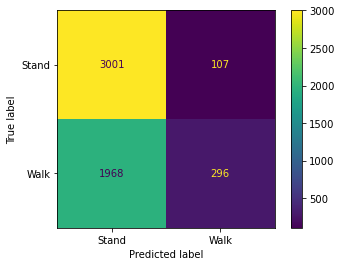

In [88]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_test, uy_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp = disp.plot()

#plt.savefig('confusion_matricies/c4_f113_km' + str(NUMBER_OF_CLUSTERS) + '+sw24_12+cae.png') # number of classes, features, method
plt.show()

# CNN

In [30]:
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Activation
from keras.models import Sequential

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(6, 64), padding="same"))
model.add(MaxPooling1D(2, padding="valid"))
#model.add(Conv1D(64, 3, activation="relu", padding="same"))
#model.add(MaxPooling1D(2, padding="valid"))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 6, 64)             12352     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                12352     
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 260       
Total params: 24,964
Trainable params: 24,964
Non-trainable params: 0
_________________________________________________________________


In [10]:
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
lb.fit([0,1,2,3])

LabelBinarizer()

In [31]:
from keras.callbacks import TensorBoard

model.fit(encoded_train, lb.transform(y_train), epochs=15, batch_size=100, callbacks=[TensorBoard(log_dir='/tmp/cnn')])

Epoch 1/15
389/389 [==============================] - 2s 5ms/step - loss: 0.6364
Epoch 2/15
389/389 [==============================] - 1s 2ms/step - loss: 0.3601
Epoch 3/15
389/389 [==============================] - 1s 2ms/step - loss: 0.3037
Epoch 4/15
389/389 [==============================] - 1s 2ms/step - loss: 0.2852
Epoch 5/15
389/389 [==============================] - 1s 2ms/step - loss: 0.2706
Epoch 6/15
389/389 [==============================] - 1s 2ms/step - loss: 0.2514
Epoch 7/15
389/389 [==============================] - 1s 2ms/step - loss: 0.2430
Epoch 8/15
389/389 [==============================] - 1s 2ms/step - loss: 0.2526
Epoch 9/15
389/389 [==============================] - 1s 2ms/step - loss: 0.2346
Epoch 10/15
389/389 [==============================] - 1s 2ms/step - loss: 0.2401
Epoch 11/15
389/389 [==============================] - 1s 2ms/step - loss: 0.2272
Epoch 12/15
389/389 [==============================] - 1s 2ms/step - loss: 0.2176
Epoch 13/15
389/389 [====

In [32]:
predicted = model.predict(encoded_test)
predicted = np.round(predicted)
predicted = lb.inverse_transform(predicted)

In [33]:
from sklearn.metrics import f1_score

print(f1_score(y_test, predicted, average='weighted'))

0.9182430991930184


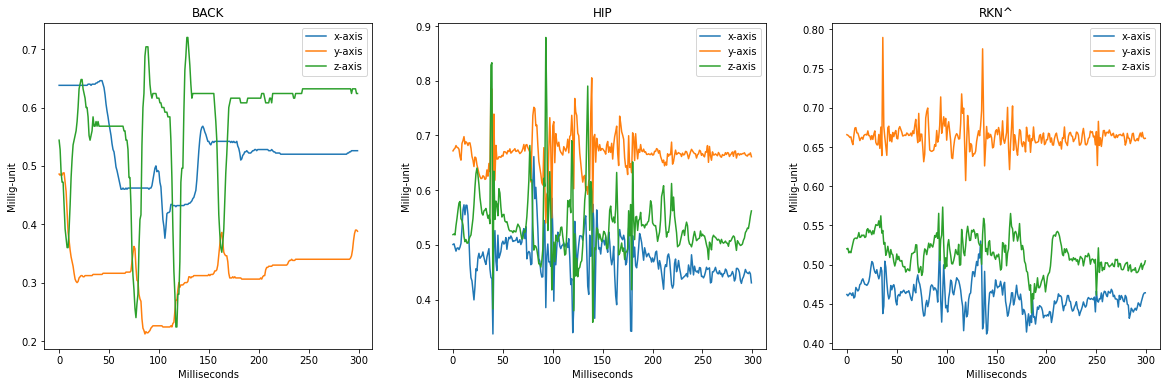

In [18]:
def column(matrix, i):
    return [row[i] for row in matrix]

def plot_sensor(ax, index, data, length, title, xlabel, ylabel):
    time = list(range(0,length))
    x = column(X_train, data[0])[:length]
    y = column(X_train, data[1])[:length]
    z = column(X_train, data[2])[:length]
    
    ax[index].plot(time, x, label="x-axis")
    ax[index].plot(time, y, label="y-axis")
    ax[index].plot(time, z, label="z-axis")
    ax[index].set(title=title, xlabel=xlabel, ylabel=ylabel)
    ax[index].legend(loc="upper right")


fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=3)
plot_sensor(ax, 0, [36,37,38], 300, "BACK", "Milliseconds", "Millig-unit")
plot_sensor(ax, 1, [0,1,2], 300, "HIP", "Milliseconds", "Millig-unit")
plot_sensor(ax, 2, [3,4,5], 300, "RKN^", "Milliseconds", "Millig-unit")